In [3]:
%reload_ext autoreload
%autoreload 3

import mne
import numpy as np
from src.EEGNet.preprocessing import utils
from pathlib import Path
import re
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, robust_scale

# data directories
data_path = f'/Volumes/Extreme SSD/PhD/MPI-LEMON/EEG_Raw_BIDS_ID/'
mpi_path = f'/Volumes/EEG_MPILMBB_LEMON/EEG_Preprocessed_BIDS_ID/EEG_Preprocessed/'

### Which data are excluded from MPI dataset for processing?

In [2]:
# get all subject ids in preprocessed folder
sub_ids_pro = []
for subject_path in sorted(Path(mpi_path).glob('sub-*')):
  sub_ids_pro.append(re.search('sub-(.*)_(.*)', subject_path.stem).group(1))
sub_ids_pro = set(sub_ids_pro)  # drop duplicates

# get all subject ids in raw folder
sub_ids_raw = []
for subject_path in sorted(Path(data_path).glob('sub-*')):
  sub_ids_raw.append(re.search('sub-(.*)', subject_path.stem).group(1))
sub_ids_raw = set(sub_ids_raw)  # drop any possible duplicates

# find any ids in sub_ids_raw that are not in sub_ids_pro
sub_ids_excluded = sorted(list(sub_ids_pro - sub_ids_raw))

## TODO: delete the entire cell: Annotations & Data Segmentation
### Data with different annotation patterns

In [124]:
fnames_annot_misbehave = {}
sub_ids_raw = []
for subject_path in sorted(Path(data_path).glob('sub-*')):
  sub_id = subject_path.stem
  sub_ids_raw.append(subject_path.stem)
  raw = mne.io.read_raw_brainvision(data_path+f'/{sub_id}/RSEEG/{sub_id}.vhdr', verbose=False)
  
  # check annot names
  points = utils.annotations_checker(raw.annotations.description.copy())

  # save those with deflection
  if sum(points.values()) != 2:
     fnames_annot_misbehave[sub_id] = points

### 1. segment and preprocess data with common annotation patterns

In [136]:
sub_ids_normal = sorted(list(set(sub_ids_raw) - set(fnames_annot_misbehave.keys())))
output_path = '/Volumes/Extreme SSD/PhD/MPI-LEMON/EEG_Raw_segmented/'
rsfreq = 250

In [138]:
for sub_id in sub_ids_normal[:5]:
    raw = mne.io.read_raw_brainvision(data_path+f'/{sub_id}/RSEEG/{sub_id}.vhdr', verbose=False)
    onsets, pattern = utils.find_pattern(raw)
    raws = utils.segment_raw(raw, onsets, pattern, duration=60)

    # save EC/EO segments in brainvision format
    ## create subject folder
    subject_path = output_path + sub_id
    Path(subject_path).mkdir(parents=True, exist_ok=True)
    ## downsample and save
    for k in raws.keys():
        raws[k].resample(rsfreq)
        raws[k].export(subject_path + f'/{sub_id}_{k}.vhdr')

### 2. segment raw data with not common annotation patterns

In [ ]:
typ1 = ['sub-010026']
# an extera ''New Segment/', 'Comment/no USB Connection to actiCAP' markers in the beginning.

typ2 = ['sub-010030']
#an extera ''New Segment/', 'Comment/no USB Connection to actiCAP' markers in the beginning without extra switch markers.

typ3 = ['sub-010062', 'sub-010064', 'sub-010134'] # only one switch markers in the beginning 

typ4 = ['sub-010191'] # an extra 'New Segment/' 'Comment/no USB Connection to actiCAP' 'Stimulus/S  1' markers in the beginning.

typ5 = ['sub-010264'] # no switch markers in the beginning

# ----------------------------------------------
typ6 = ['sub-010126']
# this subject there is no switch markers, and the annotation for eye closed is 'Stimulus/S208'

# no switch markers in the annotations, and there is only two useless markers in the beginning
typ7 = ['sub-010138', 'sub-010155', 'sub-010157',
        'sub-010162', 'sub-010163', 'sub-010164', 'sub-010165',
        'sub-010166', 'sub-010168', 'sub-010228', 'sub-010233',
        'sub-010239', 'sub-010255', 'sub-010257', 'sub-010258',
        'sub-010260', 'sub-010261', 'sub-010262', 'sub-010263',
        'sub-010267', 'sub-010268', 'sub-010269', 'sub-010270',
        'sub-010271', 'sub-010272', 'sub-010273', 'sub-010274',
        'sub-010275', 'sub-010284', 'sub-010311', 'sub-010315',
        'sub-010318']

## Divide data to eye closed and eye open segments

In [ ]:
# Check if all the switch markers's onsets are the same as the beginning of the EC/EO segments
sanity_check = {}
all_eo = []
all_ec = []
subject_ids = []
for subject_path in sorted(Path(data_path).glob('sub-*')):
    sub_id = subject_path.stem
    subject_ids.append(sub_id)
    print('>>>>>>', sub_id)
    raw = mne.io.read_raw_brainvision(data_path+f'/{sub_id}/RSEEG/{sub_id}.vhdr', verbose=False,
                                      eog=['VEOG'])

    # create a dictionary of annotations
    desc = utils.change_annot_names(raw.annotations.description.copy(),
                                    enumerated=True)
    onsets = raw.annotations.onset.copy()
    annot_dict = {k: v for k, v in zip(desc, onsets)}

    # find the points where a switch between EC/EO happens
    switch_onsets, switch_pattern = utils.find_switch_onset_pattern(annot_dict)
    
    # segment raw data based on switch points
    raws = utils.segment_raw(raw, switch_onsets, switch_pattern, duration=60)
    
    # check if the segments are correct (only EC or EO in each segment)
    for s in ['EC', 'EO']:
        sanity_check[sub_id + '_' + s] = utils.check_segments(raws[s])
    
    raw_EO = raws['EO']
    raw_EO = raw_EO.pick(picks='eeg')
    
    raw_EC = raws['EC']
    raw_EC = raw_EC.pick(picks='eeg')
    del raws
    
    all_eo.append(raw_EO.resample(128).get_data())
    all_ec.append(raw_EC.resample(128).get_data())
    
# create a dataset
ds = xr.Dataset({'eye_open': (['subject', 'channel', 'timestep'], all_eo),
                 'eye_closed': (['subject', 'channel', 'timestep'], all_ec)},)

# add subject ids to the dataset and save
ds.coords['subject'] = subject_ids
ds.to_netcdf('eeg_eo_ec.nc5', engine='h5netcdf')
ds.close()

## Pre-processing

In [92]:
# Helper functions
# clamp
def clamp_eeg(data, axis=2, deviation=20):
    """Clamp EEG data proportional to the standard deviation of each channel."""
    # container for clamped data
    data_clamped = np.zeros_like(data)
    upper_dev = data.mean(axis=axis) + data.std(axis=axis) * deviation
    lower_dev = data.mean(axis=axis) - data.std(axis=axis) * deviation
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_clamped[i, j, :] = np.clip(data[i, j, :], lower_dev[i, j], upper_dev[i, j])
    return data_clamped

def print_min_max(data, lower_dev, upper_dev, sub, channel):
    """Prints the min and max of a channel and checks if it would be clamped by the clamp_eeg function
    This is used to check if the clamp function is working as expected."""
    if data[sub, channel, :].min() < lower_dev[sub, channel] or data[sub, channel, :].max() > upper_dev[sub, channel]:
        print(f'Data: {sub}, {channel}: Min={data[sub, channel, :].min()}, Max={data[sub, channel, :].max()}',
              f'Bounderies: Lower={lower_dev[sub, channel]}, Higher={upper_dev[sub, channel]}')

### Baseline Correction

In [ ]:
# open dataset
da_name = 'eye_open'
ds = xr.open_dataset('eeg_eo_ec.nc5', engine='h5netcdf')
subject_ids = ds.subject.values
da = ds[da_name]
del ds

# convert to numpy array
data_eo = da.to_numpy()
del da

# baseline correction
data_eo = data_eo - data_eo[:, :, :int(128*0.5)].mean(axis=2, keepdims=True)

# save
data_eo = xr.DataArray(data_eo, dims=['subject', 'channel', 'timestep'])
data_eo.coords['subject'] = subject_ids
data_eo.to_netcdf('eeg_EO_BaseCorr.nc5', engine='h5netcdf')

### Normalization & Clamping

In [2]:
# open baseline corrected data
da = xr.open_dataarray('eeg_EO_BaseCorr.nc5', engine='h5netcdf')
da = da.sel(subject=da.subject.values[:5]).to_numpy()

# normalize
data = np.array(
          [RobustScaler().fit_transform(da[i, :, :]) for i in range(da.shape[0])]
        )
print(data.min(), data.max())

# clamp
data_clamped = clamp_eeg(data)

## Feature Extraction
### Connectivity

In [67]:
import simsimd

# compute cosine similarity
similarity_all = np.zeros((data_clamped.shape[0], 1830))  # 1830 is the lenght of the upper triangle of the similarity matrix
for sub in range(data_clamped.shape[0]):
    similarity = simsimd.cdist(data_clamped[sub, :, :], data_clamped[sub, :, :], metric='cosine')
    similarity = similarity[np.triu_indices(similarity.shape[0], k=1)]
    similarity_all[sub, :] = similarity

### Average over brain areas

In [1]:
import xarray as xr
import numpy as np
import mne
import torch
import numpy as np

ba_patches = {'LF': ['Fp1', 'F3', 'F7', 'AF3', 'F1', 'F5', 'AF7'],
 'LC': ['C3', 'T7', 'FC1', 'FC3', 'FC5', 'C1', 'C5', 'FT7'],
 'LP': ['P3', 'P7', 'CP1', 'CP3', 'CP5', 'TP7', 'P1', 'P5'],
 'LO': ['O1', 'PO3', 'PO7', 'PO9'],
 'RF': ['Fp2', 'F4', 'F8', 'AF4', 'F2', 'F6', 'AF8'],
 'RC': ['C4', 'T8', 'FC2', 'FC4', 'FC6', 'C2', 'C6', 'FT8'],
 'RP': ['P4', 'P8', 'CP2', 'CP4', 'CP6', 'TP8', 'P2', 'P6'],
 'RO': ['O2', 'PO4', 'PO8', 'PO10'],
 'FZ': ['Fz', 'AFz'],
 'CZ': ['Cz'],
 'PZ': ['Pz', 'CPz'],
 'OZ': ['POz', 'Oz'],
}

data = xr.open_dataset('data/LEMON_data/xarray/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5')

In [61]:
# average over each brain area patch and save in a new empty dataset
C, S, T = len(ba_patches), data.sizes.get('subject'), data.sizes.get('time')
data_numpy = np.zeros([C, S, T])
positions_numpy = np.zeros([C, 2])
for i, (v) in enumerate(ba_patches.values()):
    data_numpy[i, :, :] = data.sel(channel=v).mean(dim='channel').to_array()
    idx = [data.channel.values.tolist().index(i) for i in v]
    positions_numpy[i, :] = data.ch_positions[idx].mean(axis=0)

# create a new dataset
data_ba = xr.DataArray(data_numpy, dims=['brain_area', 'subject', 'time'],
                       coords={'brain_area': list(ba_patches.keys()),
                               'subject': data.subject.values},
                        attrs=data.attrs)
data_ba.attrs['ch_positions'] = positions_numpy

<xarray.DataArray (brain_area: 12, subject: 202, time: 61440)>
array([[[ 1.3637312 ,  1.3226057 ,  1.15811962, ..., -1.92498333,
         -1.93057055, -1.91969661],
        [ 0.32801807,  0.38882257,  0.34736976, ..., -0.95123757,
         -0.94644505, -0.9651839 ],
        [ 0.12444811,  0.13476481,  0.38391717, ..., -0.28614083,
         -0.25051004, -0.29295317],
        ...,
        [-0.85488353,  0.47153667, -1.00307655, ..., -2.00086697,
         -2.07528406, -2.10580406],
        [-0.03299134, -0.20705868, -0.13495096, ..., -1.06705762,
         -1.09186209, -0.88442991],
        [-0.05328721,  0.15291257,  0.5722472 , ..., -1.26046934,
         -1.46579999, -1.43172234]],

       [[ 0.17785706,  0.25730642,  0.43105656, ..., -0.13789054,
         -0.17339704, -0.19218732],
        [-0.11672652,  0.20717892,  0.06997659, ..., -0.25389141,
         -0.26302814, -0.16605372],
        [-0.50464223, -0.10587359, -0.14797282, ..., -0.0678349 ,
         -0.1204019 , -0.14294362],
...
        [ 0.78702529,  0.59066693,  0.5786058 , ..., -0.08710066,
         -0.09114873, -0.10129872],
        [ 1.26481539,  0.94166826,  0.34885014, ...,  0.15604068,
          0.30577591,  0.39851263],
        [ 0.56239732, -0.2262812 , -0.5014096 , ...,  0.21196734,
          0.27787051,  0.24700043]],

       [[-1.88215053, -1.55027962, -0.79431473, ...,  0.2554754 ,
          0.28288429,  0.29939158],
        [-1.17323415, -0.9360154 , -0.31167214, ...,  0.09352783,
         -0.05914827, -0.0875948 ],
        [ 0.63587408,  0.7052182 ,  0.68415693, ...,  0.11798936,
          0.12475309,  0.16487897],
        ...,
        [-0.29565428,  0.9061406 ,  1.58869259, ...,  0.40748216,
          0.39775542,  0.35896506],
        [ 0.63834421,  0.43195109,  0.48341685, ...,  0.8680799 ,
          0.86259884,  0.84625896],
        [ 0.88520155,  0.54643557,  0.01251661, ...,  0.42797281,
          0.42417115,  0.39460571]]])
Coordinates:
  * brain_area  (brain_area) <U2 'LF' 'LC' 'LP' 'LO' ... 'FZ' 'CZ' 'PZ' 'OZ'
  * subject     (subject) <U10 'sub-010002' 'sub-010003' ... 'sub-010321'
Dimensions without coordinates: time
Attributes:
    ch_positions:  [[0.22630095 0.84541231]\n [0.15437105 0.55346507]\n [0.18...
    gender:        [1 1 1 2 1 1 2 1 1 2 1 2 1 2 1 2 2 2 1 1 2 1 1 1 2 1 1 1 1...
    wellbeing:     [36. 31. 35. 39. 36. 36. 32. 38. 36. nan 36. 25. 34. 24. 3...
    alertness:     [40. 17. 36. 39. 29. 36. 31. 35. 40. nan 24. 11. 20. 28. 2...
    calmness:      [36. 27. 34. 39. 35. 39. 29. 39. 38. nan 36. 22. 30. 27. 3...

Text(0.5, 1.0, 'Averaged layouts')

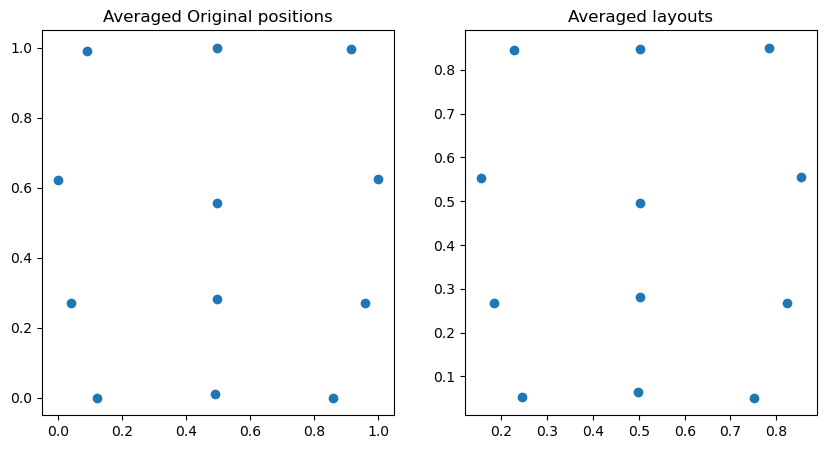

In [55]:
# check if averaging over channels layouts renders similar results as averaging over original positions
EEG = mne.io.read_raw_brainvision('data/raw/sub-010005/RSEEG/sub-010005.vhdr')
EEG.set_channel_types({'VEOG': 'eog'})
montage = mne.channels.make_standard_montage('standard_1020')
EEG.set_montage(montage)
EEG.pick(['eeg'])

positions = EEG.get_montage().get_positions()['ch_pos']
aver_pos = {}
for k, chs in ba_patches.items():
    idx = np.array([positions[ch] for ch in chs]).mean(axis=0)
    aver_pos[k] = idx
    
# create a montage with the new positions
montage = mne.channels.make_dig_montage(ch_pos=aver_pos, coord_frame='head')

# create a EEG info from these new channel positions
info = mne.create_info(ch_names=list(ba_patches.keys()), sfreq=128, ch_types='eeg')

# add positions to the info object
info.set_montage(montage)

layout = mne.channels.find_layout(info)
position = torch.full((len(info.ch_names), 2), -0.1)
x, y = layout.pos[:, :2].T
x = (x - x.min()) / (x.max() - x.min())
y = (y - y.min()) / (y.max() - y.min())
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
position[:, 0] = x
position[:, 1] = y

# plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(x, y)
axs[0].set_title('Averaged Original positions')
axs[1].scatter(positions_numpy[:, 0], positions_numpy[:, 1])
axs[1].set_title('Averaged layouts')